# Scikit-Optimize for Bayesian Optimisation

In this notebook, we will use `skopt` for Bayesuab optimisation on a toy problem. 

In [5]:
# Dependencies,
import numpy as np
import matplotlib.pyplot as plt

# SKOPT imports,
from skopt import gp_minimize
from skopt.space import Real
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import RBF, ConstantKernel
from skopt import Optimizer
from joblib import dump, load

### Toy Example

Creating our toy black-box function $f(x)$,

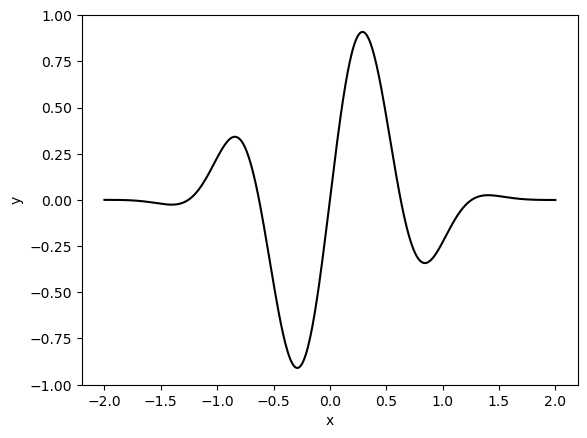

In [40]:
def f(x):
    """Our unknown black-box function."""
    return np.sin(5*x) * (1 - np.tanh(x**2))

# Plotting our black-box function,
x_vals = np.linspace(-2, 2, 400)
plt.plot(x_vals, f(x_vals), color="black")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Now we use a Gaussian Process Regression (GPR) to construct the surrogate function and use LCB as the acquisition function to find the global maximum of our black-box function $f$. Note that we have to define an objective function as $J(x) = -f(x)$ since `skopt.gp_minimize` minimises the objective function it is supplied; by minimising $-f(x)$, we maximise $f(x)$.

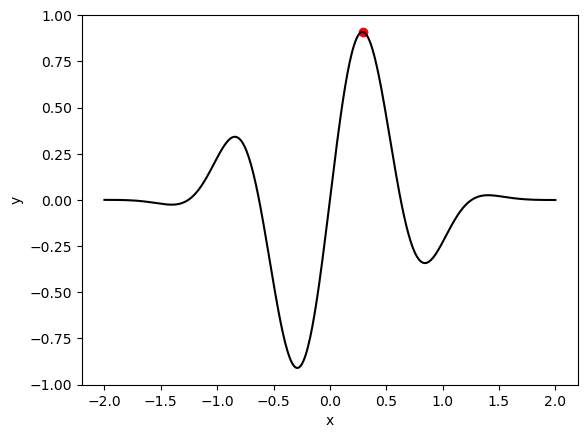

In [41]:
def objective(x):
    """We define an objective function that will be minimised."""
    return -f(x[0])

# We define the domain of the black-box function (or the range of the parameter values we want to consider),
space = [Real(-2.0, 2.0, name='x')]

# Creating the kernel for the GPR,
kernel = ConstantKernel(1.0) * RBF(length_scale=1.2)

# GPR settings,
gpr = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=False,
    n_restarts_optimizer=10
)

# Running the optimisation algorithm,
res = gp_minimize(
    func=objective,      # the function to minimize
    dimensions=space,    # the search space
    base_estimator=gpr,  # surrogate funnction
    acq_func="LCB",      # acquisition function,
    kappa=10,            # LCB parameter,
    n_calls=25,          # number of function evaluations
    n_random_starts=5,   # initial random evaluations
    random_state=0
)

# Extracting optimal parameter,
x_optim = res.x[0]

# Plotting,
x_vals = np.linspace(-2, 2, 400)
plt.plot(x_vals, f(x_vals), color="black")
plt.scatter(x_optim, f(x_optim), color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

We can also visualise the surrogate model (also known as the posterior mean $\mu(x)$ in the context of GPR) and the uncertainty or variance $\sigma(x)$,

C:\Users\Prithvi\AppData\Roaming\Python\Python312\site-packages\skopt\learning\gaussian_process\gpr.py:355: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


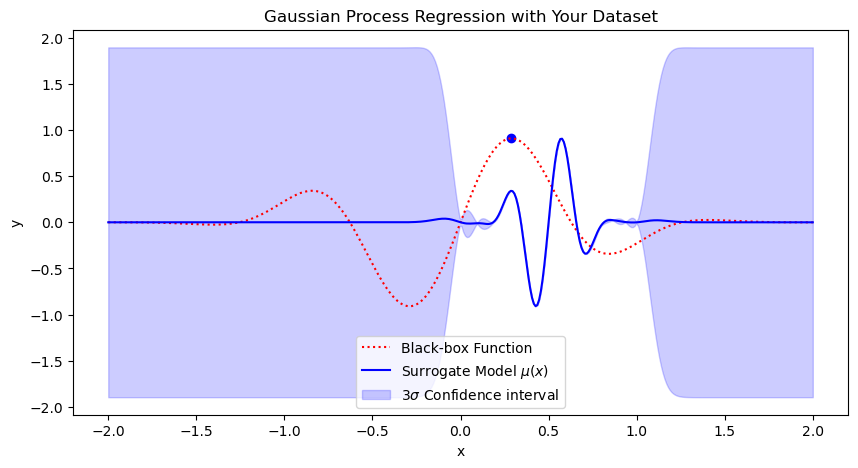

In [42]:
# Computing the posterior mean and variance,
final_gp = res.models[-1] # <-- Extracting the final GPR model.
mean, std = final_gp.predict(x_vals.reshape(-1, 1), return_std=True)
mean = -mean # <-- Flip it (due to choice of objective function)

# Plotting,
plt.figure(figsize=(10, 5))
plt.plot(x_vals, f(x_vals), "r:", label="Black-box Function")
plt.plot(x_vals, mean, "b-", label=r"Surrogate Model $\mu(x)$")
plt.fill_between(x_vals,
                mean - 3 * std,
                mean + 3 * std,
                alpha=0.2, color="blue", label=r"3$\sigma$ Confidence interval")
plt.scatter(x_optim, f(x_optim), color="blue")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Gaussian Process Regression with Your Dataset')
plt.show()

Notice that the surrogate function appears to be a horizontally squished version of the black-box model despite the algorithm finding its global maximum.

### Synthetic Example

Let us consider the following multivariate function,

$$
f(x_1, x_2, x_3, x_4) = \sin(5x_1)(1-\tanh(x_4^2)) + \cos(3x_2) + \sin(3 x_3)
$$

When we restrict its domain to $[0, 1]^4$, it has a single global maximum at $(\frac{\pi}{10}, 0, \frac{\pi}{6}, 0)$ where $f = 3$.

In [6]:
def f(x1, x2, x3, x4):
    """Our unknown multivariate black-box function."""
    return np.sin(5*x1) * (1 - np.tanh(x4**2)) + np.cos(3*x2) + np.sin(3*x3)

Let us first manually find the maximum of this function via grid search 

In [3]:
class GridSearch():

    def __init__(self, space, func):
        self.space = space
        self.function = func
        self.eval_points = None

    def search():
        pass

Let us now find the maximum using Bayesian optimisation,

In [7]:
def objective(x):
    """We define an objective function that will be minimised."""
    x1, x2, x3, x4 = x
    return -f(x1, x2, x3, x4)

# We define the domain of the black-box function (or the range of the parameter values we want to consider),
space = [Real(0, 1, name="x1"),
         Real(0, 1, name="x2"),
         Real(0, 1, name="x3"),
         Real(0, 1, name="x4")
         ]

# Creating the kernel for the GPR,
kernel = ConstantKernel(1.0) * RBF(length_scale=1.2)

# GPR settings,
gpr = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=False,
    n_restarts_optimizer=10
)

# Running the optimisation algorithm,
res = gp_minimize(
    func=objective,      # the function to minimize
    dimensions=space,    # the search space
    base_estimator=gpr,  # surrogate funnction
    acq_func="LCB",      # acquisition function,
    kappa=1,            # LCB parameter,
    n_calls=25,          # number of function evaluations
    n_random_starts=5,   # initial random evaluations
    random_state=0
)

# Extracting optimal parameter,
sol = res.x
func_max = f(x1=sol[0], x2=sol[1], x3=sol[2], x4=sol[3])

# Printing,
print(f"f={func_max} at {sol}.")

f=2.999803743896092 at [0.3149930416431217, 0.0, 0.5193114619271942, 0.010239805606032212].


However, in the Captsone project, the black-box function cannot be evaluated on our hardware. In `skopt`, the `Optimizer` class has been created with this exact use case in mind. Let us first setup the optimiser by selecting GPR for the construction of the surrogate function and LCB as the acquisition function,

In [8]:
# We define the domain of the black-box function (or the range of the parameter values we want to consider),
space = [Real(0, 1, name="x1"),
         Real(0, 1, name="x2"),
         Real(0, 1, name="x3"),
         Real(0, 1, name="x4")
         ]

# Creating the kernel for the GPR,
kernel = ConstantKernel(1.0) * RBF(length_scale=1.2)

# GPR settings,
gpr = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=False,
    n_restarts_optimizer=10
)

# Creating optimisier,
opt = Optimizer(
    dimensions=space,
    base_estimator=gpr,
    acq_func="LCB",
    acq_func_kwargs={"kappa": 1.0},
    random_state=0
)

Below we simulate the Capstone project workflow. Of course, in the real project, we will not have access to evaluate the black-box function on demand.

In [9]:
# Known evaluations,
X_known = [[0.5, 1.0, 0.5, 0.25]]
y_known = [0.5686187529092999]

# Supplying known points to optimiser,
opt.tell(X_known, (-np.array(y_known)).tolist()) # <-- We flip the values since we are trying to maximise the black-box function.

n_iters = 25
for i in range(n_iters):

    # Generating the next point query,
    point_query = opt.ask()

    # Evaluating the black-box function at point query,
    func_evaluation = f(x1=point_query[0], x2=point_query[1], x3=point_query[2], x4=point_query[3])

    # Returning new evaluation to the optimiser,
    opt.tell(point_query, -func_evaluation)

    # Printing,
    print(f"f(X) evaluated at {point_query} yielding {func_evaluation}")

f(X) evaluated at [0.5488135039273249, 0.7151893663724196, 0.602763376071644, 0.544883182996897] yielding 0.7037470653474087
f(X) evaluated at [0.4236547993389048, 0.6458941130666562, 0.4375872112626926, 0.89177300078208] yielding 0.8973120129922798
f(X) evaluated at [0.9636627605010295, 0.3834415188257778, 0.7917250380826648, 0.5288949197529046] yielding 0.3784817017884702
f(X) evaluated at [0.5680445610939324, 0.9255966382926613, 0.07103605819788696, 0.08712929970154072] yielding -0.42812011694088903
f(X) evaluated at [0.020218397440325723, 0.8326198455479382, 0.7781567509498507, 0.8700121482468194] yielding -0.04115484143909942
f(X) evaluated at [0.9786183422327642, 0.7991585642167238, 0.46147936225293196, 0.7805291762864557] yielding -0.20198734038936395
f(X) evaluated at [0.11827442586893325, 0.6399210213275239, 0.14335328740904643, 0.9446689170495841] yielding 0.23523683097093673
f(X) evaluated at [0.5218483217500718, 0.4146619399905237, 0.264555612104627, 0.7742336894342169] yie

In the actual project, we will have the following workflow,

In [14]:
"""INITALISING THE OPTIMISATION MODEL."""

# Inputting the given evaluations provided by the problem,
X_supplied = [[0.5, 1.0, 0.5, 0.25]]
y_supplied = [0.5686187529092999]

"""OPTIMISER SETTINGS."""

# We define the domain of the black-box function (or the range of the parameter values we want to consider),
space = [Real(0, 1, name="x1"),
         Real(0, 1, name="x2"),
         Real(0, 1, name="x3"),
         Real(0, 1, name="x4")
         ]

# Creating the kernel for the GPR,
kernel = ConstantKernel(1.0) * RBF(length_scale=1.2)

# GPR settings,
gpr = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=False,
    n_restarts_optimizer=10
)

# Creating optimisier,
opt = Optimizer(
    dimensions=space,
    base_estimator=gpr,
    acq_func="LCB",
    acq_func_kwargs={"kappa": 1.0},
    random_state=0
)

"""CREATING INTIAL OPTIMISER STATE."""

# Supplying given points to optimiser,
opt.tell(X_supplied, (-np.array(y_supplied)).tolist()) # <-- We flip the values since we are trying to maximise the black-box function.

# Asking for the next point to evaluate the black-box function,
point_query = opt.ask()

# Saving optimiser state (zero-th iteration),
dump(opt, "bayes_opt_state_iter0.joblib")

# Printing point query,
print(f"Point Query: {point_query}")

Point Query: [0.5488135039273249, 0.7151893663724196, 0.602763376071644, 0.544883182996897]


Now that we have created the initial state of the optmiser from the known evaluations given by the problem, we now iteratively update the optimiser. 

In [23]:
# Specify the current interation,
current_query = 4

# Input the new evaluation,
X_new = [[0.5680445610939324, 0.9255966382926613, 0.07103605819788696, 0.08712929970154072]]
y_new = [-0.428120116940889]

# Loading the previous state of the optimiser,
opt = load(f"bayes_opt_state_iter{current_query - 1}.joblib")

# Supplying the new query to the optimiser,
opt.tell(X_new, (-np.array(y_new)).tolist()) # <-- We flip the values since we are trying to maximise the black-box function.

# Asking for the next point to evaluate the black-box function,
point_query = opt.ask()

# Saving optimiser state,
dump(opt, f"bayes_opt_state_iter{current_query}.joblib")

# Printing point query,
print(f"Point Query {current_query + 1}: {point_query}")

Point Query 5: [0.020218397440325723, 0.8326198455479382, 0.7781567509498507, 0.8700121482468194]


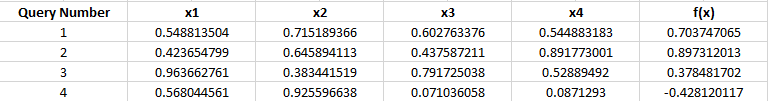